시계열
  - https://www.kaggle.com/datasets/kirolosatef/netflex-stock-dataset-with-twitter-sentiment?resource=download
  - RNN
  - 데이터
    - 순서대로 입력
  - 모델
    - 과거정보와 현재정보르 모두 가져야함
    - 과거의출력을 다시 입력으로 넣어주어야 함
    - Recursive + 인공신경망 = RNN

    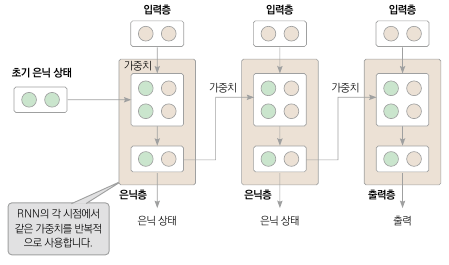


In [4]:
!unzip /content/drive/MyDrive/netflex.zip

Archive:  /content/drive/MyDrive/netflex.zip
replace Final_nflx_data_2018-2022.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Final_nflx_data_2018-2022.csv  


In [6]:
import pandas as pd
data = pd.read_csv('/content/Final_nflx_data_2018-2022.csv')
data.head()

,date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-02,196.100006,201.649994,195.419998,201.070007,201.070007,10966900,0.020833,10,480
1,2018-01-03,202.050003,206.210007,201.500000,205.050003,205.050003,8591400,0.071217,24,337
2,2018-01-04,206.199997,207.050003,204.000000,205.630005,205.630005,6029600,-0.018519,-4,216
3,2018-01-05,207.250000,210.020004,205.589996,209.990005,209.990005,7033200,-0.019737,-6,304
4,2018-01-08,210.020004,212.500000,208.440002,212.050003,212.050003,5580200,-0.007663,-2,261


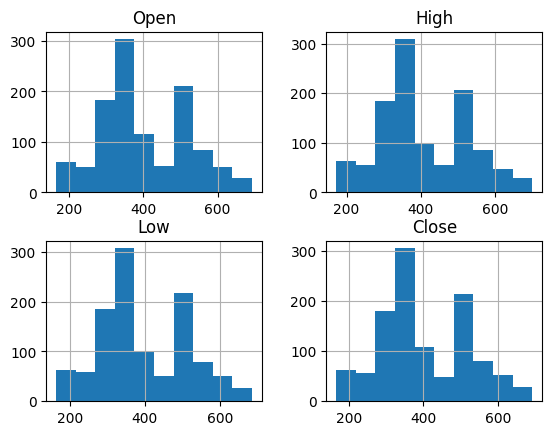

In [9]:
# 입력데이터는 Open	High	Low
# 정답 Close
import matplotlib.pyplot as plt
data_used = data.iloc[:,1:5]
# data_used['Close'] = data['Close']
data_used.hist()
plt.show()


In [ ]:
# 신경망의 학습.. 오차역전파, 출력값이 크면 오차범위가 크고->기울기도 커지고
# 원할한 학습을 위해 0 ~ 1사이로 정규화  minmax로 정규화
# 단점은 이상치가 있으면 사용을 보류...

학습용 데이터  생성
  - Dataset() 객체..
    - _ _ init _ _() 초기화
    - _ _ len _ _ () 데이터 개수
    - _ _ getitem _ _() 특정 데이터를 획득

In [27]:
# 30일을 배치단위로 설정
import numpy as np
from torch.utils.data.dataset import Dataset

In [41]:
class Netflix(Dataset):
  def __init__(self):
    self.csv = pd.read_csv('/content/Final_nflx_data_2018-2022.csv')
    # 학습용 데이터 정규화
    self.data = self.csv.iloc[:,1:4].values
    self.data = self.data / np.max(self.data)  # 0 ~ 1 정규화

    # 타겟용 종가데이터 정규화
    self.label = self.csv['Close'].values
    self.label = self.label / np.max(self.label)
  def __len__(self):
    return len(self.data) - 30  # 사용가능한 배치 개수
  def __getitem__(self, index):
    data = self.data[index: index+30]
    label = self.label[index+30]
    return data,label

In [42]:
dataset = Netflix()
next(iter(dataset))[0].shape

(30, 3)

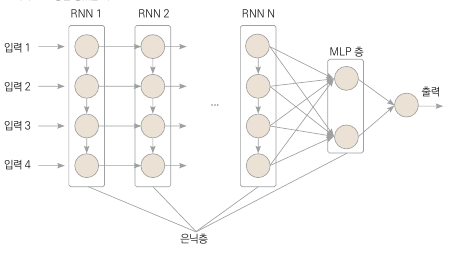

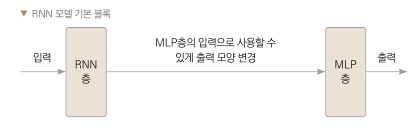

RNN 모델 구현

In [43]:
import torch
import torch.nn as nn
class RNN(nn.Module):
  def __init__(self):
    super(RNN,self).__init__()
    # rnn 정의
    self.rnn = nn.RNN(input_size=3,hidden_size=8,num_layers=5,batch_first=True)  # (32,30,3)(batchsize,windowsize,featuresize)

    # 출력을 위한 MLP층 정의
    self.fc1 = nn.Linear(in_features=240, out_features=64)  # 시계열의 windowsize 30, hidden 8  30*8 240
    self.fc2 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU()
  def forward(self,x,h0):
    # rnn 출력
    x, hn = self.rnn(x, h0)  # 출력이 두개  x는 마지막 rnn층의 은닉상태 hn 모든 Rnn의 은닉 상태

    # 모양 변경
    x = torch.reshape(x, (x.shape[0], -1))

    # mlp 층
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)  # mlp층의 최종 출력은 (배치개수,1)

    # 예측한 값 1차원 벡터로 표현
    x = torch.flatten(x)
    return x

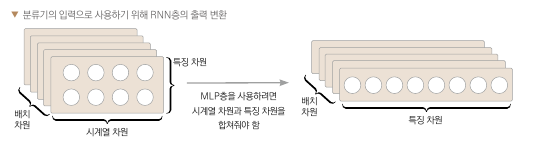

모델 및 데이터셋 생성

In [44]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNN().to(device)
dataset = Netflix()
loader = DataLoader(dataset,batch_size=32)

#최적화
lr = 1e-4
optim = Adam(model.parameters(),lr=lr)

In [45]:
a = pd.read_csv('/content/Final_nflx_data_2018-2022.csv')
a['Close'].values.shape

(1137,)

학습

In [ ]:
for epoch in range(200):
  iterdata = tqdm.tqdm(loader)
  for data, label in iterdata:
    optim.zero_grad()
    #초기 은닉상태
    # (은닉층의개수,배치크기,출력차원)
    h0 = torch.zeros(5,data.shape[0],8).to(device)
    pred = model(data.type(torch.FloatTensor).to(device),h0)
    loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
    loss.backward()
    optim.step()
    iterdata.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),'rnn.pth')

In [50]:
from torch.utils.data import dataloader
import matplotlib.pyplot as plt
loader = DataLoader(dataset,batch_size=1)
preds = []
total_loss = 0
with torch.no_grad():
  model.load_state_dict( torch.load('rnn.pth',map_location=device))
  for data,label in loader:
    h0 = torch.zeros(5,data.shape[0],8).to(device)
    pred = model(data.type(torch.FloatTensor).to(device),h0)
    preds.append(pred.item())
    loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
    total_loss += loss/len(loader)
total_loss.item()

0.0010370454983785748

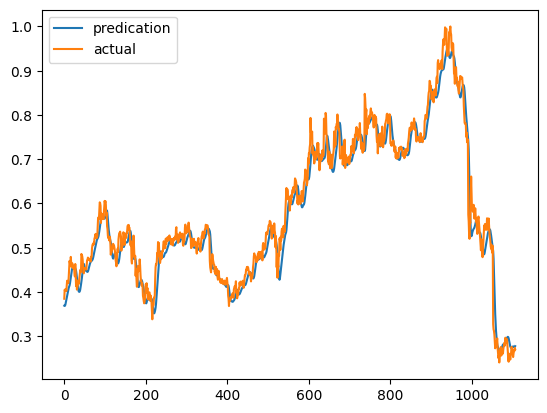

In [51]:
import matplotlib.pyplot as plt
plt.plot(preds,label='predication')
plt.plot(dataset.label[30:],label='actual')
plt.legend()
plt.show()

-------------------------------------------------------------------

In [74]:
class Netflix(Dataset):
  def __init__(self):
    self.csv = pd.read_csv('/content/Final_nflx_data_2018-2022.csv')
    # 학습용 데이터 정규화
    self.data = self.csv.iloc[:,1:4].values
    self.data = self.data / np.max(self.data)  # 0 ~ 1 정규화

    # 타겟용 종가데이터 정규화
    self.label = self.csv['Close'].values
    self.label = self.label / np.max(self.label)
  def __len__(self):
    return len(self.data) - 15  # 사용가능한 배치 개수
  def __getitem__(self, index):
    data = self.data[index: index+15]
    label = self.label[index+15]
    return data,label

import torch
import torch.nn as nn
class RNN(nn.Module):
  def __init__(self):
    super(RNN,self).__init__()
    # rnn 정의
    self.rnn = nn.RNN(input_size=3,hidden_size=16,num_layers=5,batch_first=True)  # (32,30,3)(batchsize,windowsize,featuresize)
    # 출력을 위한 MLP층 정의
    self.fc1 = nn.Linear(in_features=240, out_features=64)  # in_features : 윈도우사이즈 x hidden_size
    self.fc2 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU()
  def forward(self,x,h0):
    # rnn 출력
    x, hn = self.rnn(x, h0)  # 출력이 두개  x는 마지막 rnn층의 은닉상태 hn 모든 Rnn의 은닉 상태
    # X의 모양은 (입력데이터배치사이즈, 윈도우사이즈, hidden_size)
    # print(f"after rnn shape:{x.shape}")
    # 모양 변경
    x = torch.reshape(x, (x.shape[0], -1))  # -- (입력데이터배치사이즈, 윈도우사이즈 x hidden_size)
    # mlp 층
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)  # mlp층의 최종 출력은 (배치개수,1)

    # 예측한 값 1차원 벡터로 표현
    x = torch.flatten(x)
    return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = RNN().to(device)
dataset = Netflix()
loader = DataLoader(dataset,batch_size=32)

In [75]:
# batchsize = 32  windowsize = 15, feature = 3
for data, label in loader:
  print(data.shape, label.shape)
  break
# input_size=3,hidden_size=16,num_layers=5

torch.Size([32, 15, 3]) torch.Size([32])


In [76]:
#초기 은닉상태
# (num_layers,배치크기(입력데이터의크기-배치),hidden_size)
h0 = torch.zeros(5,data.shape[0],16).to(device)
pred = model(data.type(torch.FloatTensor).to(device),h0)

after rnn shape:torch.Size([32, 15, 16])


In [77]:
for epoch in range(200):
  iterdata = tqdm.tqdm(loader)
  for data, label in iterdata:
    optim.zero_grad()
    #초기 은닉상태
    # (은닉층의개수,배치크기,출력차원)
    h0 = torch.zeros(5,data.shape[0],16).to(device)
    pred = model(data.type(torch.FloatTensor).to(device),h0)
    loss = nn.MSELoss()(pred,label.type(torch.FloatTensor).to(device))
    loss.backward()
    optim.step()
    iterdata.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),'rnn.pth')

epoch:0 loss:0.14718416333198547:  31%|███       | 11/36 [00:00<00:00, 54.34it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:0 loss:0.3475777208805084:  47%|████▋     | 17/36 [00:00<00:00, 54.89it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:0 loss:0.3056972324848175:  81%|████████  | 29/36 [00:00<00:00, 52.81it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:0 loss:0.020610155537724495: 100%|██████████| 36/36 [00:00<00:00, 49.27it/s]


after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([2, 15, 16])


epoch:1 loss:0.19048810005187988:   0%|          | 0/36 [00:00<?, ?it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.0962013378739357:  14%|█▍        | 5/36 [00:00<00:00, 43.02it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.14592771232128143:  28%|██▊       | 10/36 [00:00<00:00, 38.84it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.13066424429416656:  39%|███▉      | 14/36 [00:00<00:00, 39.00it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.2029617726802826:  50%|█████     | 18/36 [00:00<00:00, 34.34it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.3475777208805084:  50%|█████     | 18/36 [00:00<00:00, 34.34it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.4099370241165161:  61%|██████    | 22/36 [00:00<00:00, 28.98it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.48850131034851074:  72%|███████▏  | 26/36 [00:00<00:00, 28.29it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.16723470389842987:  86%|████████▌ | 31/36 [00:00<00:00, 31.96it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:1 loss:0.020610155537724495: 100%|██████████| 36/36 [00:01<00:00, 33.61it/s]


after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([2, 15, 16])


epoch:2 loss:0.07803358882665634:   0%|          | 0/36 [00:00<?, ?it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.1385980248451233:  14%|█▍        | 5/36 [00:00<00:00, 39.57it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.0962013378739357:  14%|█▍        | 5/36 [00:00<00:00, 39.57it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.09099581092596054:  25%|██▌       | 9/36 [00:00<00:00, 35.59it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.15521995723247528:  39%|███▉      | 14/36 [00:00<00:00, 38.12it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.34009385108947754:  39%|███▉      | 14/36 [00:00<00:00, 38.12it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.3948313891887665:  78%|███████▊  | 28/36 [00:00<00:00, 55.00it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.3056972324848175:  78%|███████▊  | 28/36 [00:00<00:00, 55.00it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.01978362537920475:  97%|█████████▋| 35/36 [00:00<00:00, 58.92it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:2 loss:0.020610155537724495: 100%|██████████| 36/36 [00:00<00:00, 51.54it/s]


after rnn shape:torch.Size([2, 15, 16])


epoch:3 loss:0.1470329761505127:   0%|          | 0/36 [00:00<?, ?it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.15974858403205872:  22%|██▏       | 8/36 [00:00<00:00, 78.41it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.09099581092596054:  22%|██▏       | 8/36 [00:00<00:00, 78.41it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.07251320779323578:  22%|██▏       | 8/36 [00:00<00:00, 78.41it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.34009385108947754:  44%|████▍     | 16/36 [00:00<00:00, 70.08it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.4099370241165161:  67%|██████▋   | 24/36 [00:00<00:00, 70.03it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.3948313891887665:  67%|██████▋   | 24/36 [00:00<00:00, 70.03it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.6512603759765625:  67%|██████▋   | 24/36 [00:00<00:00, 70.03it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:3 loss:0.020610155537724495:  92%|█████████▏| 33/36 [00:00<00:00, 73.72it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([2, 15, 16])


epoch:4 loss:0.1385980248451233:   0%|          | 0/36 [00:00<?, ?it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.08258125185966492:   0%|          | 0/36 [00:00<?, ?it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.0962013378739357:  22%|██▏       | 8/36 [00:00<00:00, 67.14it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.07251320779323578:  22%|██▏       | 8/36 [00:00<00:00, 67.14it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.24915127456188202:  44%|████▍     | 16/36 [00:00<00:00, 71.75it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.36666807532310486:  44%|████▍     | 16/36 [00:00<00:00, 71.75it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.4099370241165161:  67%|██████▋   | 24/36 [00:00<00:00, 74.08it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.6512603759765625:  67%|██████▋   | 24/36 [00:00<00:00, 74.08it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:4 loss:0.01978362537920475:  89%|████████▉ | 32/36 [00:00<00:00, 74.37it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([2, 15, 16])


epoch:5 loss:0.07803358882665634:   0%|          | 0/36 [00:00<?, ?it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.1283121407032013:   0%|          | 0/36 [00:00<?, ?it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.0962013378739357:  19%|█▉        | 7/36 [00:00<00:00, 63.77it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.07251320779323578:  19%|█▉        | 7/36 [00:00<00:00, 63.77it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.13066424429416656:  42%|████▏     | 15/36 [00:00<00:00, 70.07it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.2029617726802826:  42%|████▏     | 15/36 [00:00<00:00, 70.07it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.35109686851501465:  64%|██████▍   | 23/36 [00:00<00:00, 70.91it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.48850131034851074:  64%|██████▍   | 23/36 [00:00<00:00, 70.91it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.6512603759765625:  64%|██████▍   | 23/36 [00:00<00:00, 70.91it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.16723470389842987:  86%|████████▌ | 31/36 [00:00<00:00, 71.13it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:5 loss:0.020610155537724495: 100%|██████████| 36/36 [00:00<00:00, 72.26it/s]


after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([2, 15, 16])


epoch:6 loss:0.1283121407032013:   0%|          | 0/36 [00:00<?, ?it/s] 

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.0962013378739357:  22%|██▏       | 8/36 [00:00<00:00, 78.27it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.15974858403205872:  22%|██▏       | 8/36 [00:00<00:00, 78.27it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.14592771232128143:  22%|██▏       | 8/36 [00:00<00:00, 78.27it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.07251320779323578:  22%|██▏       | 8/36 [00:00<00:00, 78.27it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.15521995723247528:  44%|████▍     | 16/36 [00:00<00:00, 70.94it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.36666807532310486:  44%|████▍     | 16/36 [00:00<00:00, 70.94it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.4099370241165161:  67%|██████▋   | 24/36 [00:00<00:00, 70.16it/s]

after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])
after rnn shape:torch.Size([32, 15, 16])


epoch:6 loss:0.4019206166267395:  67%|██████▋   | 24/36 [00:00<00:00, 66.56it/s]


KeyboardInterrupt: ignored